# BeatBag
This is an entry in the SparkFun Crowdsourcing Algorithms Contest: https://www.sparkfun.com/news/2115

In [130]:
import numpy as np
import csv

import matplotlib.pyplot as plt
%matplotlib inline  

In [131]:
def lpf(alpha, x, y_old):
    return (y_old + alpha * (x - y_old))

def hpf(alpha, x, x_old, y_old):
    return (alpha * (y_old + x - x_old))

def vector_mag(x,y):
    return (np.sqrt(x**2 + y**2))

## Locate the data

In [132]:
data_path = '.\\data\\Recorded Tests\\'
#data_path +=  '3-77hits.TXT'
#data_path +=  '4-81hits.TXT'
data_path +=  '5-93hits.TXT'
#data_path +=  '6-79hits.TXT'
#data_path +=  'MysteryDataSet-1.TXT'
#data_path +=  'MysteryDataSet-2.TXT'

## Initialize variables

In [133]:
sampletime = 0.002
timeconstant = 0.100
alpha = (float)(sampletime / (sampletime+timeconstant))

x_lpf=0.0
y_lpf=0.0
z_lpf=0.0

x_lpf_old=0.0
y_lpf_old=0.0
z_lpf_old=0.0

x_hpf=0.0
y_hpf=0.0
z_hpf=0.0

x_hpf_old=0.0
y_hpf_old=0.0
z_hpf_old=0.0

## Read and process each line of the file

4.885 0.621912667852 -0.453144647639
10.13 0.323434949746 -0.303596782578
10.446 0.316783603897 -0.250654188368
11.976 0.316209664247 -0.561356438833
12.264 0.298387667684 -0.459504879142
12.902 0.280088882077 -0.289522051169
13.487 0.285297233308 -0.243677747233
13.806 0.321023488294 -0.276753210834
14.117 0.446726993173 -0.25767716799
14.119 0.263275903907 -0.246329167364
14.608 0.206101863511 -0.29597566577
15.087 0.319901319977 -0.257276873747
17.112 0.466401139965 -0.591485488454
17.397 0.3445595856 -0.239951743551
18.043 0.389203645685 -0.35633063452
18.548 0.663581264955 -0.583366142823
18.828 0.205732867549 -0.589350965836
19.097 0.291384978138 -0.318247981542
19.121 0.57419095491 -0.542662619179
20.342 0.401300060499 -0.377979172663
20.555 0.251510816476 -0.24499386392
20.816 0.297566816299 -0.401776053068
20.837 0.657210967595 -0.322705174945
21.791 0.259331859237 -0.311772150887
21.995 0.399774550742 -0.360531792499
22.87 0.421403325214 -0.239916619928
24.03 0.235075382982 -

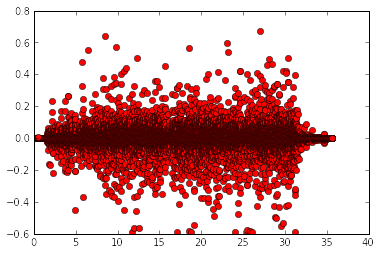

In [137]:
hitcount = 0

with open(data_path, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        try:           
            timestamp_ms, x, y, z = row
        except ValueError:
            pass

        x=float(x)
        y=float(y)
        z=float(z)            

        #Signal Processing
        #for now, this is lowpass followed by high pass filters.
        #later, time dependent filter vaules
        x_lpf = lpf(alpha, x, x_lpf)
        x_hpf = hpf(alpha, x_lpf, x_lpf_old, x_hpf_old)
        x_lpf_old = x_lpf
        x_hpf_old = x_hpf
        
        y_lpf = lpf(alpha, y, y_lpf)
        y_hpf = hpf(alpha, y_lpf, y_lpf_old, y_hpf_old)
        y_lpf_old = y_lpf
        y_hpf_old = y_hpf

        z_lpf = lpf(alpha, z, z_lpf)
        z_hpf = hpf(alpha, z_lpf, z_lpf_old, z_hpf_old)
        z_lpf_old = z_lpf
        z_hpf_old = z_hpf        
        
        #calculate a vector in plane of the bag platform
        c = vector_mag(x_hpf, y_hpf)   
        
        plt.plot(float(timestamp_ms)/1000.0, z_hpf, 'ro')
        
        #hit_count_logic
        if (c > .2): #every punch imparts a force in the plane of the platform
            if (z_hpf<-.23): #and toward the ground
                hitcount+=1
                print float(timestamp_ms)/1000, c, z_hpf                
                

print hitcount
plt.show()